In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
pip install foolbox==2.4

     |████████████████████████████████| 1.9MB 4.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 40.0MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
  Created wheel for foolbox: filename=foolbox-2.4.0-cp36-none-any.whl size=1926223 sha256=fbe751b106da19c0c8f2ce00fec4079c61f98b28aa8bd28d49444c078d1cc461
  Stored in directory: /root/.cache/pip/wheels/ae/5a/11/a5b42761c70dd38c674d889f6ce7edc9867d0262f95de8712b
Successfully built foolbox


In [ ]:
cd '/content/gdrive/My Drive'

/content/gdrive/My Drive


In [ ]:
import os
import sys
import foolbox
import argparse
import tensorflow as tf

from classification_models.keras import Classifiers
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
from random import randint
from copy import copy
import time

print(sys.version)
print(tf.__version__)

from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
1.15.2


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
def loadCIFAR(test=False, train=False) :
    cifar100 = tf.keras.datasets.cifar100
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    '''
    (x_train1, y_train), (x_test1, y_test) = cifar100.load_data()
    x_train = x_train1.astype('float32') / 255
    x_test = x_test1.astype('float32') / 255'''

    image, label, labelf = [], [], []
    if test :
        for i in range(len(x_test)) :
            if y_test[i] == 88 : # tigre (88) 
                label.append([0,1])
                image.append(x_test[i])
                labelf.append(1)
            if y_test[i] == 42 and not train : # lion  (42)
                label.append([1,0])
                image.append(x_test[i])
                labelf.append(0)
            if y_test[i] == 90 and train: # train  (90)
                label.append([1,0])
                image.append(x_test[i])
                labelf.append(0)
    else :
        for i in range(len(y_train)) :
            if y_train[i] == 88 : # tigre (88) 
                label.append([0,1])
                labelf.append(1)
                image.append(x_train[i])
            if y_train[i] == 42 and not train: # lion  (42)
                label.append([1,0])
                image.append(x_train[i])
                labelf.append(0)
            if y_train[i] == 90 and train: # train  (90)
                label.append([1,0])
                image.append(x_train[i])
                labelf.append(0)

    image = np.array(image)
    label = np.array(label)
    labelf = np.array(labelf)
    return image, label, labelf

def printCPTTime(sec) :
    sec = int(sec)
    if sec <60 :
        print("00:"+str(sec))
    elif sec<3600 : 
        print(str(sec//60)+":"+str(sec%60))
    else :
        reste = sec%3600
        print(str(sec//3600)+":"+str(reste//60)+":"+str(reste%60))
    
def giveTime() :
    return str(time.localtime()[3])+":"+str(time.localtime()[4])

In [ ]:
beforeTrain, afterTrain = np.array([]), np.array([])
attackK = np.array([])

def start(kIter=500, lastK=1, nbEpoch=2, batchSize=256, filePath="modelCifar2", TT=False) :
    global beforeTrain, afterTrain, attackK
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    if not os.path.exists(filePath):
        os.makedirs(filePath)

    if not os.path.exists(filePath+"/dataset"):
        os.makedirs(filePath+"/dataset")

    # Charge les images
    image, label, labelf = loadCIFAR(False,TT)
    N = len(image)

    # Creer le modèle
    # model = ResNet50(input_shape=[32,32,3], include_top=True, classes=2, weights=None)
    model = ResNet18(input_shape=[32,32,3], include_top=True, classes=2, weights=None)
    optim = tf.compat.v1.train.AdamOptimizer(1e-4)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(optim, loss, metrics=['accuracy'])

    # Si un model existe déjà, le charger sinon en entrainer un
    if os.path.exists(filePath+"/Madry"+str(lastK)) :
        print(giveTime()+" >>> Load Madry")
        model.load_weights(filePath+'/Madry'+str(lastK))
    else :
        print(giveTime()+" >>> Train Madry")
        model.fit(image, label, epochs=200, batch_size=256)
        model.save_weights(filePath+'/Madry0')
    
    
    k=lastK+1
    while k<=kIter :
        print(giveTime()+" >>> New Iter "+str(k)+"/"+str(kIter))
        
        nbBatch = int(N/batchSize)
        
        for i in range(nbBatch) :
            batch = image[i*batchSize:i*batchSize+batchSize]
            
            # Générer PGD images
            print(" >>> Generate new PGD pictures "+str(i))
            foolModel = foolbox.models.KerasModel(model, bounds=(0, 255))
            attack = foolbox.attacks.L2BasicIterativeAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
            PGD = attack(image[i*batchSize:i*batchSize+batchSize], labelf[i*batchSize:i*batchSize+batchSize], epsilon=5.0 , stepsize=0.06, iterations=200, return_early=True, random_start=True) 
            
            PGD_acc = np.mean(model.predict(PGD).argmax(axis=-1) == labelf[i*batchSize:i*batchSize+batchSize])
            print(giveTime()+" >>> PGD"+str(nbBatch*k+i)+" acc "+str(PGD_acc))
            np.save(filePath+"/dataset/PGD"+str(nbBatch*k+i), PGD)

            print(giveTime()+" >>> Fit ")
            model.fit(PGD,label[i*batchSize:i*batchSize+batchSize], epochs=nbEpoch, batch_size=batchSize)
        
        model.save_weights(filePath+'/Madry'+str(k))

        k+=1

In [ ]:
start(kIter=30, lastK=25, filePath="resnetCifarTT_Madry_PGD3", nbEpoch=1, TT=True, batchSize=50)

# Load Data

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [ ]:
image, label, labelf = loadCIFAR(False,True)
imageTest, labelTest, labelTestf = loadCIFAR(True,True)

169009152/169001437 [==============================] - 3s 0us/step


In [ ]:
ResNet18, preprocess_input = Classifiers.get('resnet18')

filePath="resnetCifarTT_Madry_PGD3"
batchSize, maxIter = 50, 30
nbBatch = int(len(image)/batchSize)

model = ResNet18(input_shape=[32,32,3], include_top=True, classes=2, weights=None)
optim = tf.train.AdamOptimizer(1e-4)
loss=tf.keras.losses.MeanSquaredError()
model.compile(optim, loss, metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
foolModel = foolbox.models.KerasModel(model, bounds=(0, 255))
attack = foolbox.attacks.L2BasicIterativeAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)

In [ ]:
def loadDatas(iterMax,batchSize) :
    global theClassifieurs, allPGD
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    f0 = ResNet18(input_shape=[32,32,3], include_top=True, classes=10, weights=None)
    optim = tf.compat.v1.train.AdamOptimizer(1e-4)
    f0.compile(optim, loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
    theClassifieurs = np.array([copy(f0) for i in range(iterMax+1)])
    
    theClassifieurs[0].load_weights(filePath+'/Madry'+str(0))
    
    allPGD = [[] for i in range(iterMax+1)]
    allPGD[0] = np.array(image)
    for k in range(1,iterMax+1) : 
        theClassifieurs[k].load_weights(filePath+'/Madry'+str(k))

        PGD_k = np.array([])
        nbBatch = int(len(image)/batchSize)
        for i in range(nbBatch) :
          PGD_i = np.load(filePath+"/dataset/PGD"+str(nbBatch*k+i)+".npy")

          if PGD_k.size == 0 :
              PGD_k = np.array(PGD_i)
          else :
              PGD_k = np.concatenate((PGD_k,PGD_i))
          
        allPGD[k] = PGD_k

In [ ]:
loadDatas(maxIter,batchSize)

/tensorflow-1.15.2/python3.6/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
/tensorflow-1.15.2/python3.6/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Distance

Norme

In [ ]:
byK = []
for k in range(1,maxIter+1) :
    print(k)
    eqm  = tf.keras.losses.MSE(image/255,allPGD[k]/255)
    byK.append(sess.run(eqm).mean())

In [ ]:
MinMax = [1.14624145e-05, 3.6801226e-05, 3.4034852e-05, 6.219612e-05, 6.707477e-05, 5.0394323e-05, 0.0012381815, 0.0015811936, 0.0015832648, 0.057851814, 0.055887323, 0.05165388, 0.05098417, 0.04958687, 0.04937178, 0.048560336, 0.04662025, 0.045327216, 0.044386033, 0.044035323, 0.044024542, 0.043765303, 0.04363932, 0.043639693, 0.042384844, 0.04260362, 0.041717727, 0.041635666, 0.041354902, 0.041066837]

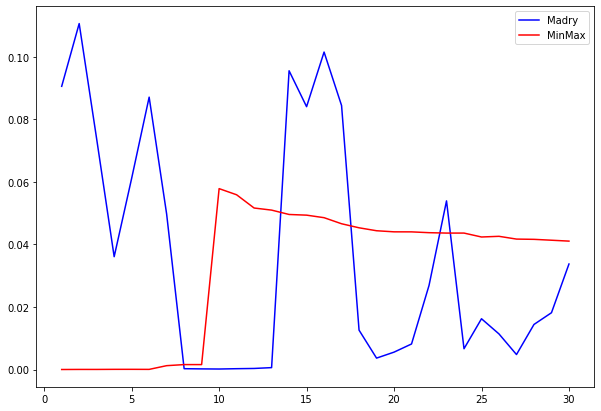

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot([i+1 for i in range(maxIter)], byK, 'b', label="Madry")
plt.plot([i+1 for i in range(maxIter)], MinMax, 'r', label="MinMax")
plt.legend()

In [ ]:
byI = []
for k in range(1,maxIter+1) :
    print(k)
    for i in range(nbBatch) :
      PGD_ki = np.load(filePath+"/dataset/PGD"+str(nbBatch*k+i)+".npy")
      eqm  = tf.keras.losses.MSE(image[i*batchSize:i*batchSize+batchSize]/255,PGD_ki/255)
      byI.append(sess.run(eqm).mean())

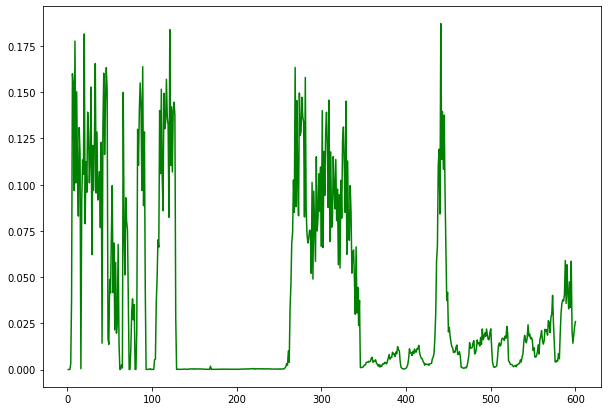

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot([i+1 for i in range(nbBatch*maxIter)], byI, 'g', label="Prediction Image")

Prédiction


In [ ]:
PGD_Test = np.array([])
for k in range(0,maxIter+1) :
  model.load_weights(filePath+'/Madry'+str(k))
  foolModel = foolbox.models.KerasModel(model, bounds=(0, 255))
  attack = foolbox.attacks.GradientSignAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance) # L2BasicIterativeAttack
  adv = attack(image, labelf, epsilons=2000, max_epsilon=1)
  
  if PGD_Test.size == 0 :
      PGD_Test = np.array([adv])
  else :
      PGD_Test = np.concatenate((PGD_Test,[adv]))

In [ ]:
predictN, predictT, predictT0, predictNT = [], [], [], []

for k in range(0,maxIter+1) :    
    predictNT.append(np.mean(theClassifieurs[k].predict(imageTest).argmax(axis=-1) == labelTestf))
    predictN.append(np.mean(theClassifieurs[k].predict(image).argmax(axis=-1) == labelf))
    
    if k != 0 :
      predictT0.append(np.mean(theClassifieurs[k-1].predict(PGD_Test[k]).argmax(axis=-1) == labelTestf))
    else :
      predictT0.append(0)

    predictT.append(np.mean(theClassifieurs[k].predict(PGD_Test[k]).argmax(axis=-1) == labelTestf))  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


(-1.5, 31.5, 0.0, 1.1)

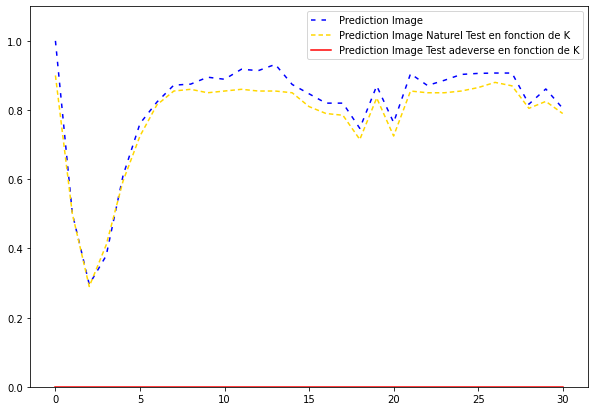

In [ ]:
plt.rcParams["figure.figsize"] = (10,7) #(8,5)
plt.plot([i for i in range(maxIter+1)], predictN, 'b', label="Prediction Image", dashes=[3, 4])
plt.plot([i for i in range(maxIter+1)], predictNT, 'gold', label="Prediction Image Naturel Test en fonction de K", dashes=[3, 2])
plt.plot([i for i in range(maxIter+1)], predictT, 'red', label="Prediction Image Test adeverse en fonction de K")#, dashes=[6, 2])
#plt.plot([i for i in range(1,maxIter+1)], predictT0[1:], 'y', label="Prediction Image Test adeverse par Fk en fonction de K-1", dashes=[10, 3])
#plt.plot([i for i in range(maxIter+1)], predictZ, 'y', label="Prediction Zk  par Fk-1 en fonction de K", dashes=[3, 2])
#plt.plot([i for i in range(maxIter+1)], predictZF, 'purple', label="Prediction de Zk par Zfinal en fonction de K")
#plt.plot([i for i in range(maxIter+1)], [0.5 for i in range(maxIter+1)], 'orange', label="Y=0.5")
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1.1))

# Show Image Exemple

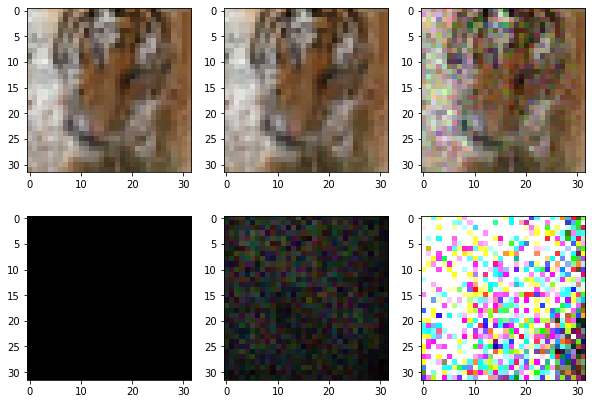

In [ ]:
imgNum, plt.rcParams["figure.figsize"] = 10, (10,7)

model.load_weights(filePath+'/Madry'+str(maxIter))
if model.predict(image[imgNum:imgNum+1]).argmax(axis=-1) != labelf[imgNum:imgNum+1] : 
  print("diff")

model = ResNet18(input_shape=[32,32,3], include_top=True, classes=2, weights=None)
optim = tf.compat.v1.train.AdamOptimizer(1e-4)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optim, loss, metrics=['accuracy'])

plt.subplot(2, 3, 1)
plt.imshow(image[imgNum])

model.load_weights(filePath+'/Madry0')
foolModel = foolbox.models.KerasModel(model, bounds=(0, 255))
attack = foolbox.attacks.L2BasicIterativeAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
ad0 = attack(image[imgNum:imgNum+1], labelf[imgNum:imgNum+1], epsilon=5.0 , stepsize=0.05, iterations=200, return_early=True)
plt.subplot(2, 3, 2)
plt.imshow(np.asarray(ad0[0], dtype=int))

model.load_weights(filePath+'/Madry'+str(maxIter))
foolModel = foolbox.models.KerasModel(model, bounds=(0, 255))
attack = foolbox.attacks.L2BasicIterativeAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
adf = attack(image[imgNum:imgNum+1], labelf[imgNum:imgNum+1], epsilon=5.0 , stepsize=0.05, iterations=200, return_early=True)
plt.subplot(2, 3, 3)
plt.imshow(np.asarray(adf[0], dtype=int))

plt.subplot(2, 3, 4)
plt.imshow(np.absolute(image[imgNum] - image[imgNum]))

diff1 = np.absolute(image[imgNum] - ad0)
diff1 = (diff1)**(1/2)
mi, ma = np.min(diff1[0]), np.max(diff1[0])
#diff1 = 255*(diff1[0]-mi)/(ma-mi)
plt.subplot(2, 3, 5)
plt.imshow(np.asarray(diff1[0]*50, dtype=int))

diff2 = np.absolute(image[imgNum] - adf)
diff2 = (diff2)**(1/2)
diff2 = np.absolute(image[imgNum] - adf)
mi, ma = np.min(diff2[0]), np.max(diff2[0])
#diff2 = 255*(diff2[0]-mi)/(ma-mi)
plt.subplot(2, 3, 6)
plt.imshow(np.asarray(diff2[0]*50, dtype=int)) #diff2[0]*10

diff


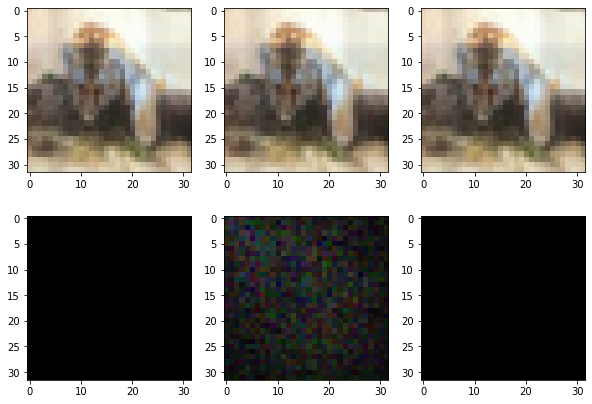

In [ ]:
imgNum, plt.rcParams["figure.figsize"] = 71, (10,7)

model.load_weights(filePath+'/Madry'+str(maxIter))
if model.predict(image[imgNum:imgNum+1]).argmax(axis=-1) != labelf[imgNum:imgNum+1] : 
  print("diff")

model = ResNet18(input_shape=[32,32,3], include_top=True, classes=2, weights=None)
optim = tf.compat.v1.train.AdamOptimizer(1e-4)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optim, loss, metrics=['accuracy'])

plt.subplot(2, 3, 1)
plt.imshow(image[imgNum])

model.load_weights(filePath+'/Madry0')
foolModel = foolbox.models.KerasModel(model, bounds=(0, 255))
attack = foolbox.attacks.L2BasicIterativeAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
ad0 = attack(image[imgNum:imgNum+1], labelf[imgNum:imgNum+1], epsilon=5.0 , stepsize=0.05, iterations=200, return_early=True)
plt.subplot(2, 3, 2)
plt.imshow(np.asarray(ad0[0], dtype=int))

model.load_weights(filePath+'/Madry'+str(maxIter))
foolModel = foolbox.models.KerasModel(model, bounds=(0, 255))
attack = foolbox.attacks.L2BasicIterativeAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
adf = attack(image[imgNum:imgNum+1], labelf[imgNum:imgNum+1], epsilon=5.0 , stepsize=0.05, iterations=200, return_early=True)
plt.subplot(2, 3, 3)
plt.imshow(np.asarray(adf[0], dtype=int))

plt.subplot(2, 3, 4)
plt.imshow(np.absolute(image[imgNum] - image[imgNum]))

diff1 = np.absolute(image[imgNum] - ad0)
diff1 = (diff1)**(1/2)
mi, ma = np.min(diff1[0]), np.max(diff1[0])
#diff1 = 255*(diff1[0]-mi)/(ma-mi)
plt.subplot(2, 3, 5)
plt.imshow(np.asarray(diff1[0]*50, dtype=int))

diff2 = np.absolute(image[imgNum] - adf)
diff2 = (diff2)**(1/2)
diff2 = np.absolute(image[imgNum] - adf)
mi, ma = np.min(diff2[0]), np.max(diff2[0])
#diff2 = 255*(diff2[0]-mi)/(ma-mi)
plt.subplot(2, 3, 6)
plt.imshow(np.asarray(diff2[0]*50, dtype=int)) #diff2[0]*10

In [ ]:
imgNum, plt.rcParams["figure.figsize"] = 11, (10,7)

tab = []

model.load_weights(filePath+'/Madry'+str(maxIter))
if model.predict(image[imgNum:imgNum+1]).argmax(axis=-1) != labelf[imgNum:imgNum+1] : 
  print("diff")

model = ResNet18(input_shape=[32,32,3], include_top=True, classes=2, weights=None)
optim = tf.compat.v1.train.AdamOptimizer(1e-4)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optim, loss, metrics=['accuracy'])

for i in range(100) :
  model.load_weights(filePath+'/Madry0')

  if model.predict(image[i:i+1]).argmax(axis=-1) != labelf[i:i+1] : 
    print(str(i)+" : 0")

  model.load_weights(filePath+'/Madry'+str(maxIter))
  if model.predict(image[i:i+1]).argmax(axis=-1) != labelf[i:i+1] : 
    print(str(i)+" : 30")

  foolModel = foolbox.models.KerasModel(model, bounds=(0, 255))
  attack = foolbox.attacks.L2BasicIterativeAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
  ad0 = attack(image[i:i+1], labelf[i:i+1], epsilon=5.0 , stepsize=0.06, iterations=200, return_early=True, random_start=True) 
  eqm  = tf.keras.losses.MSE(image[i:i+1]/255,ad0/255)
  tab.append(sess.run(eqm).mean())